In [5]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler

MERGED_DATA_DIR = "../../data/merged data"
OUTPUT_DIR = "../../output/assumption"
PROCESSED_DATA_DIR = "../../data/processed data"

# Load the dataset
tnp_20 = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2020", "merged_tnp_data.csv"))
tnp_19 = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2019", "merged_tnp_data.csv"))

scaler = StandardScaler()
cols_to_scale = ["daily_bus_rides", "rides"]
tnp_20[cols_to_scale] = scaler.fit_transform(tnp_20[cols_to_scale])
tnp_19[cols_to_scale] = scaler.fit_transform(tnp_19[cols_to_scale])

In [6]:
# 添加年份指示变量
tnp_20["is_2020"] = 1
tnp_19["is_2020"] = 0

# 拼接数据
merged_df = pd.concat([tnp_20, tnp_19], ignore_index=True)
merged_df["price"] = merged_df["fare"] + merged_df["additional_charges"]
# merged_df['price'] = np.log1p(merged_df['price'])

# 确保日期变量是 datetime 类型（后续 RDiT 会用到）
merged_df["trip_start_date"] = pd.to_datetime(merged_df["trip_start_date"])

# 创建工作日虚拟变量，drop_first=True 是为了避免虚拟变量陷阱
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='dow', drop_first=True)

# 合并到原始数据中
merged_df = pd.concat([merged_df, day_dummies], axis=1)

# 创建地区虚拟变量，drop_first=True 是为了避免虚拟变量陷阱
area_dummies = pd.get_dummies(merged_df['area_type'], prefix='at', drop_first=True)

# 合并到原始数据中
merged_df = pd.concat([merged_df, area_dummies], axis=1)

def aggregate_daily_metrics(merged_df):
    """
    Aggregate trip data by day, including:
    1. Daily averages for all attributes (first value except for 'price', which is averaged)
    2. Total taxis per day (sum over census tracts)
    3. Total trips per day
    4. Merge all into a single daily summary dataframe

    Parameters:
        merged_df (pd.DataFrame): Input dataframe with trip-level data.

    Returns:
        pd.DataFrame: Aggregated dataframe with daily averages and counts.
    """
    # 1. 所有属性，按天聚合
    agg_dict = {
        col: 'first' for col in merged_df.columns
        if col not in ['trip_start_date', 'pickup_census_tract', 'taxi', 'price']
    }
    agg_dict['price'] = 'mean'  # 显式保留平均价格
    daily_avg_df = merged_df.groupby(['trip_start_date']).agg(agg_dict).reset_index()

    # 2. taxi 按天聚合（先按小区合计，再加总）
    taxis_per_group = merged_df.groupby(['trip_start_date', 'pickup_census_tract'])['taxi'].sum().reset_index()
    taxis_per_day = taxis_per_group.groupby('trip_start_date')['taxi'].sum().reset_index(name='taxis_count')

    # 3. trip 数量（每日 trip 数）
    trips_per_day = merged_df.groupby('trip_start_date').size().reset_index(name='trips_count')

    # 4. 合并所有内容
    merged_daily_df = (
        daily_avg_df
        .merge(trips_per_day, on='trip_start_date', how='left')
        .merge(taxis_per_day, on='trip_start_date', how='left')
    )

    return merged_daily_df

low_incomes = merged_df[merged_df['Cluster'] == 0]
high_incomes = merged_df[merged_df['Cluster'] == 1]
mid_incomes = merged_df[merged_df['Cluster'] == 2]

pooled_daily_df = aggregate_daily_metrics(merged_df)
low_incomes_daily_df = aggregate_daily_metrics(low_incomes)
high_incomes_daily_df = aggregate_daily_metrics(high_incomes)
mid_incomes_daily_df = aggregate_daily_metrics(mid_incomes)


In [7]:
def plot_dif_in_rdit_fit(
    df: pd.DataFrame,
    outcome: str,
    time_var: str,
    treat_year_var: str,
    cutoff_date,
    placebo_cutoff_date="2019-01-07",
    covariates: list = None,
    trend_order: int = 1,
    bandwidth: int = 29,
    title=None,
    figsize=(6.4, 4),
    save_path=None
):
    """
    可视化 Dif-in-RDiT 的拟合曲线（Treatment 与 Placebo）对比图，包含 control variables。
    """

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.formula.api as smf
    import os

    df = df.copy()
    df[time_var] = pd.to_datetime(df[time_var])
    cutoff_date = pd.to_datetime(cutoff_date)
    placebo_cutoff_date = pd.to_datetime(placebo_cutoff_date)

    df["cutoff_for_row"] = df[treat_year_var].apply(
        lambda x: cutoff_date if x == 1 else placebo_cutoff_date
    )
    df["days_from_cutoff"] = (df[time_var] - df["cutoff_for_row"]).dt.days
    df = df[df["days_from_cutoff"].between(-bandwidth, bandwidth)]

    df["post_cutoff"] = (df["days_from_cutoff"] >= 0).astype(int)
    df["post_treat"] = df["post_cutoff"] * df[treat_year_var]

    # 添加趋势项
    trend_terms = []
    for i in range(1, trend_order + 1):
        base = f"days_from_cutoff_pow{i}"
        df[base] = df["days_from_cutoff"] ** i
        df[f"{base}_x_post"] = df[base] * df["post_cutoff"]
        df[f"{base}_x_treat"] = df[base] * df[treat_year_var]
        df[f"{base}_x_post_treat"] = df[base] * df["post_cutoff"] * df[treat_year_var]
        trend_terms += [base, f"{base}_x_post", f"{base}_x_treat", f"{base}_x_post_treat"]

    rhs = ["post_cutoff", treat_year_var, "post_treat"] + trend_terms
    if covariates:
        rhs += covariates

    formula = outcome + " ~ " + " + ".join(rhs)
    model = smf.ols(formula=formula, data=df).fit()
    df["fitted"] = model.fittedvalues

    print(model.rsquared)

    treat_df = df[df[treat_year_var] == 1].sort_values("days_from_cutoff")
    placebo_df = df[df[treat_year_var] == 0].sort_values("days_from_cutoff")

    # 绘图
    plt.figure(figsize=figsize)
    plt.scatter(
        df["days_from_cutoff"],
        df[outcome],
        facecolors='none',
        edgecolors='gray',
        alpha=0.4,
        s=20,
        label="Raw data"
    )
    plt.plot(
        treat_df["days_from_cutoff"],
        treat_df["fitted"],
        label="Treatment year fit",
        color="black",
        linewidth=1.8
    )
    plt.plot(
        placebo_df["days_from_cutoff"],
        placebo_df["fitted"],
        label="Placebo year fit",
        color="black",
        linestyle="--",
        linewidth=1.8
    )

    plt.axvline(0, color="black", linestyle=":", linewidth=1)
    plt.xlabel("Days from cutoff")
    plt.ylabel(outcome)
    if title:
        plt.title(title)
    plt.legend(frameon=False)
    plt.tight_layout()

    if save_path:
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_path, dpi=300)
        print(f"Saved to: {save_path}")

    plt.show()


0.9444613732293086
Saved to: ../../output/regression/aggregated_pooled_Dif_in_RDiT.pdf


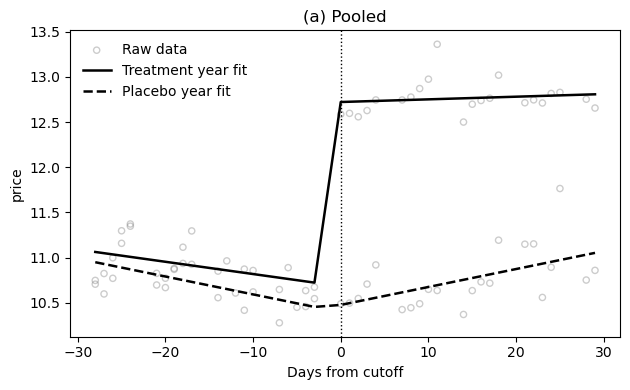

0.918435408412742
Saved to: ../../output/regression/aggregated_low_Dif_in_RDiT.pdf


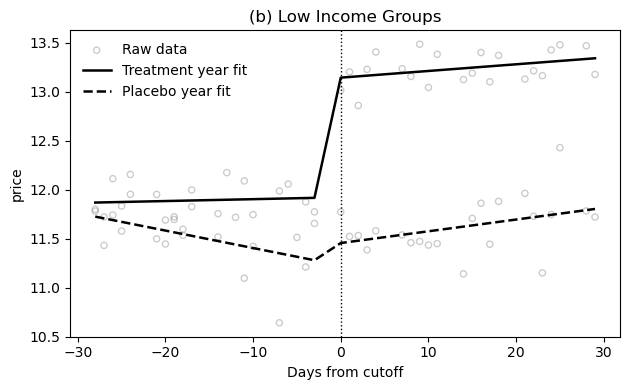

0.9413838818993537
Saved to: ../../output/regression/aggregated_high_Dif_in_RDiT.pdf


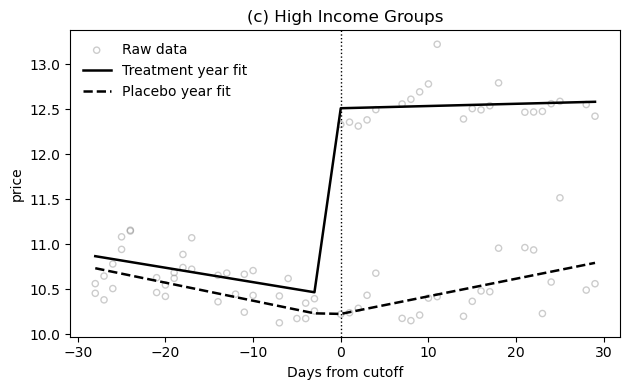

0.9346799275086609
Saved to: ../../output/regression/aggregated_mid_Dif_in_RDiT.pdf


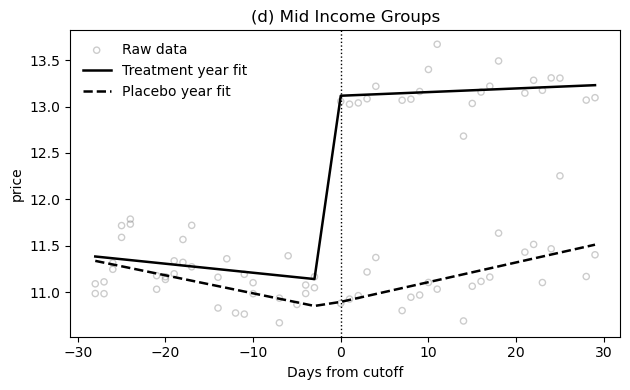

In [8]:
trip_controls = [
    "trip_seconds", "trip_miles", "trip_during_peak"
]

weather_controls = [
    "Avg_Temp_C", "Precipitation_mm",
    "Snowfall_mm", "Avg_Wind_Speed_mps",
]

substitutes_controls = [
    # "total_rides", "taxi",
    "rides", "daily_bus_rides", "taxi",
]

day_of_week_controls = ["dow_1", "dow_2", "dow_3", "dow_4"]

area_type_controls = ["at_1", "at_2"]

control_vars = (
    trip_controls
    + weather_controls
    + substitutes_controls
    + day_of_week_controls
    + area_type_controls
)

plot_dif_in_rdit_fit(
    df=pooled_daily_df,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    # covariates=control_vars,
    trend_order=1,
    bandwidth=29,
    title="(a) Pooled",
    save_path="../../output/regression/aggregated_pooled_Dif_in_RDiT.pdf"
)

plot_dif_in_rdit_fit(
    df=low_incomes_daily_df,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    # covariates=control_vars,
    trend_order=1,
    bandwidth=29,
    title="(b) Low Income Groups",
    save_path="../../output/regression/aggregated_low_Dif_in_RDiT.pdf"
)

plot_dif_in_rdit_fit(
    df=high_incomes_daily_df,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    # covariates=control_vars,
    trend_order=1,
    bandwidth=29,
    title="(c) High Income Groups",
    save_path="../../output/regression/aggregated_high_Dif_in_RDiT.pdf"
)

plot_dif_in_rdit_fit(
    df=mid_incomes_daily_df,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    # covariates=control_vars,
    trend_order=1,
    bandwidth=29,
    title="(d) Mid Income Groups",
    save_path="../../output/regression/aggregated_mid_Dif_in_RDiT.pdf"
)